#### Import all the primary non-ML packages

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

%matplotlib inline

#### Set the local path

In [2]:
import subprocess
import os

cmd = subprocess.Popen('pwd', stdout=subprocess.PIPE)
cmd_out, cmd_err = cmd.communicate()
local_path = os.fsdecode(cmd_out).strip()

In [3]:
df=pd.read_csv(local_path+"/tweets_processed.csv")

#### Load the data in 'Data_Preprocessed folder'

In [4]:
# df=pd.read_parquet(local_path+"/Data_Preprocessed/df_tweets_Shashank_features_added_part1.parquet")
# df=pd.concat([df,pd.read_parquet(local_path+"/Data_Preprocessed/df_tweets_Shashank_features_added_part2.parquet")])

#### We drop columns with textual, categorical data, and we choose the tweets with like counts higher than the threshold to be popular -- assign binary classes based on that

In [5]:
threshold = 30
df['popularity'] = df['public_metrics_like_count'].apply(lambda x: 1 if x >= threshold else 0)
feature_columns = ['entities_cashtags', 'entities_hashtags', 'entities_urls', 'entities_mentions',
                   'public_metrics_followers_count', 'public_metrics_following_count',
                   'public_metrics_tweet_count', 'Tweet_Length_characters', 'Tweet_Length_words',
                   'Word_count_News_agencies', 'Compound_vader', 'Neutral_vader', 'Positive_vader',
                   'Negative_vader']

Columns present in the tweets dataframe

In [7]:
df.columns

Index(['Unnamed: 0', 'created_at', 'entities_cashtags', 'entities_hashtags',
       'entities_urls', 'public_metrics_like_count',
       'public_metrics_quote_count', 'public_metrics_reply_count',
       'public_metrics_retweet_count', 'text', 'entities_mentions',
       'created_at_user', 'public_metrics_followers_count',
       'public_metrics_following_count', 'public_metrics_listed_count',
       'public_metrics_tweet_count', 'media_type', 'Company_name',
       'Word_count_News_agencies', 'Word_count_Henry08_pos',
       'Word_count_Henry08_neg', 'Word_count_LM11_pos', 'Word_count_LM11_neg',
       'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg',
       'Tweet_Length_characters', 'Tweet_Length_words', 'Compound_vader',
       'Positive_vader', 'Negative_vader', 'Neutral_vader'],
      dtype='object')

#### Machine learning setup

In the following cell, comment out the scoring dictionary while running multiclass classifiers.

In [ ]:
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"precision_score": make_scorer(precision_score),\
           "recall_score": make_scorer(recall_score),\
           "accuracy_score": make_scorer(accuracy_score),\
           "f1_score": make_scorer(f1_score, average="weighted"),
           "roc_auc_score": make_scorer(roc_auc_score)}


Depending on your choice of binary or three classes, uncomment the $\textit{socring}$, $\textit{refit}$ options below under the model specification. Make sure change the names and ranges of the hyperparameters
that you are tuning 

In [9]:
pipe = Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('classifier',AdaBoostClassifier())
])

model = GridSearchCV(
    pipe,
    param_grid = {
        #'classifier__max_depth':np.arange(10,70,10),
        'classifier__n_estimators':np.arange(110,210,10)},
    #scoring=scoring,
    #refit="f1_score",
    return_train_score=True,
    cv=30,
    n_jobs=10
)

Set the features and labels for the model to be trained on

In [10]:
X = df[feature_columns]
y = df.popularity

time taken : 9324.430378388002s


For classification using three classes of tweet popularity, uncomment the following cell

In [ ]:
# y=np.zeros(len(df))
# y[df['public_metrics_like_count'] >= 100] = 2
# y[(df['public_metrics_like_count'] < 100) & (df['public_metrics_like_count'] >= 20)] = 1

#### Create train-test split and fit the model & fit the model

In [ ]:
from sklearn.model_selection import train_test_split

start = time.perf_counter()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = .2,
                                                      random_state=123,
                                                      shuffle=True,
                                                      stratify=y)
model.fit(X_train, y_train)

finish = time.perf_counter()
print(f'time taken : {finish-start}s')

In [23]:
print(f'f1-score on the training set: {model.best_score_}')

0.7301091583068036

In [24]:
print(f'The model parameters: {model.best_params_}')

{'classifier__n_estimators': 200}

In [25]:
print(f'f1-score on the test set: {model.score(X_test,y_test)}')

0.7300073808807851

Store the summary of training and cross-vaalidation in $\textit{results}$

In [26]:
results=model.cv_results_

In [27]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

y_predicted=model.predict(X_test)
cm=confusion_matrix(y_test,y_predicted)
mcm=multilabel_confusion_matrix(y_test,y_predicted)

In [28]:
print(mcm)

[[[ 93782  10087]
  [ 16304  62732]]

 [[ 73955  35062]
  [ 12918  60970]]

 [[148690   4234]
  [ 20161   9820]]]


In [29]:
print(cm)

[[62732 15921   383]
 [ 9067 60970  3851]
 [ 1020 19141  9820]]


In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted, target_names=['0','1','2']))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83     79036
           1       0.63      0.83      0.72     73888
           2       0.70      0.33      0.45     29981

    accuracy                           0.73    182905
   macro avg       0.73      0.65      0.66    182905
weighted avg       0.74      0.73      0.72    182905



In [31]:
classification_report(y_test, y_predicted, target_names=['0','1','2'],output_dict=True)

{'0': {'precision': 0.8614784602919567,
  'recall': 0.7937142567943721,
  'f1-score': 0.8262092127358335,
  'support': 79036},
 '1': {'precision': 0.6348925358213928,
  'recall': 0.8251678215677782,
  'f1-score': 0.7176318267419961,
  'support': 73888},
 '2': {'precision': 0.698733456667141,
  'recall': 0.327540775824689,
  'f1-score': 0.44600885659134776,
  'support': 29981},
 'accuracy': 0.7300073808807851,
 'macro avg': {'precision': 0.7317014842601636,
  'recall': 0.6488076180622797,
  'f1-score': 0.6632832986897258,
  'support': 182905},
 'weighted avg': {'precision': 0.7432682487561505,
  'recall': 0.7300073808807851,
  'f1-score': 0.7200264797658192,
  'support': 182905}}

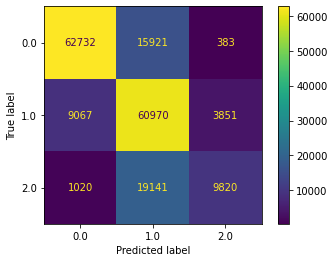

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot();

To save the summary of training and cross-valdiation into a text file, uncomment the following snippet of code 

In [33]:
# with open(local_path+"/model_20_100_ab_n_estimators_tuning1.csv","a") as csvfile:
#     writer=csv.writer(csvfile)
#     for item,value in results.items():
#         writer.writerow([item,value])

To plot the results of tuning hyperparameters through $\textit{GridSearchCV}$ uncomment the following cell. Note this only works when the $\textit{scoring}$ option is enabled while training

In [22]:
# import seaborn as sns
# sns.set()

# plt.figure(figsize=(16, 16))
# plt.title("GridSearchCV to tune n_estimators hyperparameter for the like_counts threshold set to 30", fontsize=16)

# plt.xlabel("number of esimators",fontsize=16)
# plt.ylabel("Score",fontsize=16)

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

# ax = plt.gca()
# # ax.set_xlim(0, 11)
# # ax.set_ylim(0.7, 1)

# # Get the regular numpy array from the MaskedArray
# X_axis = np.array(results["param_classifier__n_estimators"].data, dtype=float)

# for scorer, color in zip(sorted(scoring), ["g", "k", "b", "r","m"]):
#     for sample, style in (("train", "-x"), ("test", "--o")):
#         sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
#         sample_score_std = results["std_%s_%s" % (sample, scorer)]
#         ax.fill_between(
#             X_axis,
#             sample_score_mean - sample_score_std,
#             sample_score_mean + sample_score_std,
#             alpha=0.1 if sample == "test" else 0,
#             color=color,
#         )
#         ax.plot(
#             X_axis,
#             sample_score_mean,
#             style,
#             color=color,
#             alpha=1 if sample == "test" else 0.7,
#             label="%s (%s)" % (scorer, sample),
#         )

#     best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
#     best_score = results["mean_test_%s" % scorer][best_index]

#     # Plot a dotted vertical line at the best score for that scorer marked by x
#     ax.plot(
#         [
#             X_axis[best_index],
#         ]
#         * 2,
#         [0.8, best_score],
#         linestyle="-.",
#         color=color,
#         marker="x",
#         markeredgewidth=3,
#         ms=8,
#     )

#     # Annotate the best score for that scorer
#     #ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

# ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.01),fontsize=16)
# plt.legend(loc="best")
# plt.grid(True)
# plt.show()
# #plt.savefig('model_tuning_metrics_max_depth_50_min_samples_leaf_30.png');